In [157]:
from learning import regress, heatmap

import pandas as pd
from sklearn.preprocessing import PowerTransformer
from IPython.display import display

Provincia       7556
Comune          7556
Occupazione     7556
Reddito         7556
Popolazione     7556
Cibo            7556
Istruzione      7556
Natura          7556
Tempo libero    7556
Turismo         7556
dtype: int64


None

2.4450932506507073


,Occupazione,Reddito,Cibo,Istruzione,Natura,Tempo libero,Turismo
0,0.620815,0.902839,-0.020466,-0.740283,-0.706990,0.019018,0.862217
2,0.870599,1.133061,0.705447,-0.740283,0.261786,1.312722,0.289892
3,0.739906,0.241213,0.650587,0.924821,-0.006638,0.095950,0.242530
4,-0.887601,-0.331659,0.972475,-0.740283,-0.725612,-0.236440,-0.580081
5,-0.882478,-0.927406,1.840347,-0.740283,2.596351,-0.773926,2.107440


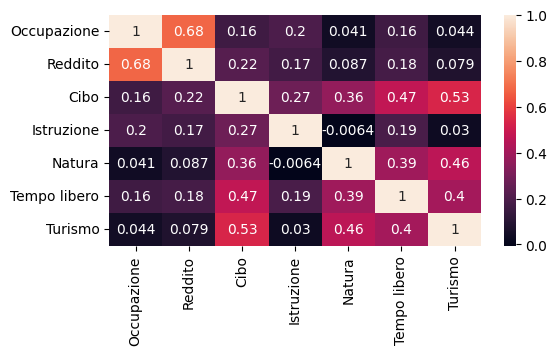

In [158]:
reddito = pd.read_csv("reddito_imponibile_2020.csv")
occupazione = pd.read_csv("occupazione_2019.csv")
strutture_ricettive = pd.read_csv("strutture_ricettive_2019.csv")
popolazione = pd.read_csv("popolazione_2019.csv")
dati_osm = pd.read_csv("dati_osm_comuni_full.csv")

input_features = ["Occupazione", "Reddito", "Cibo", "Istruzione", "Natura", "Tempo libero"]

df = pd.merge(reddito, occupazione, how="inner", left_on="Territorio", right_on="Comune")
df = df[["Provincia", "Comune", "Occupazione", "Reddito"]]
df = df.sort_values(by="Comune")

df = pd.merge(df, popolazione, how="inner", left_on="Comune", right_on="Territorio")
df = df.rename(columns={"Value": "Popolazione"})
df = df.drop(["Territorio"], axis=1)

df = pd.merge(df, dati_osm, how="inner", left_on="Comune", right_on="Comune")

df = pd.merge(df, strutture_ricettive, how="inner", left_on="Comune", right_on="Territorio")
df = df.rename(columns={"Value": "Turismo"})
df = df.drop(["Territorio"], axis=1)

missing = df[df["Turismo"].isna()]
miss_b = missing.copy()

mean_known = df[input_features + ["Popolazione", "Turismo"]].mean()
mean_known = pd.DataFrame(mean_known, columns=["Noti"])

print(df.isna().count())
df = df.dropna()

df = df.drop(["Provincia", "Comune"], axis=1)
df[["Reddito", "Cibo", "Istruzione", "Natura", "Tempo libero", "Turismo"]] = df[["Reddito", "Cibo", "Istruzione", "Natura", "Tempo libero", "Turismo"]].divide(df["Popolazione"], axis=0)
df = df.drop(["Popolazione"], axis=1)

scaler = PowerTransformer()
scaler = scaler.fit(df[input_features + ["Turismo"]])
df[input_features + ["Turismo"]] = scaler.transform(df[input_features + ["Turismo"]])

df.to_csv("final.csv", index=False)

display(heatmap(df, (6, 3), ""))
print(df["Turismo"].max())
df.head()

In [159]:
results, models = regress(df, input_features, "Turismo", get_models=True)
pd.DataFrame.from_dict(results, orient="index", columns=["MAE", "MSE", "ME"])

,MAE,MSE,ME
Linear Regression,0.616016,0.625244,3.093231
Random Forest,0.546508,0.533339,3.138511
Gradient Boosting,0.541785,0.519224,3.024717
Decision Tree,0.727601,1.002397,3.325736


In [160]:
model = models["Random Forest"]
target_pred = model.predict(missing[input_features])
missing[input_features + ["Turismo"]] = scaler.transform(missing[input_features + ["Turismo"]])
missing["Turismo"] = target_pred
missing[input_features + ["Turismo"]] = scaler.inverse_transform(missing[input_features + ["Turismo"]])
missing[input_features] = miss_b[input_features]
missing["Turismo"] = missing["Turismo"].multiply(missing["Popolazione"], axis=0)
missing.to_csv("predicted_values.csv", index=False)
missing.head()

c:\Users\Francesco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:3189: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1


,Provincia,Comune,Occupazione,Reddito,Popolazione,Cibo,Istruzione,Natura,Tempo libero,Turismo
1,LO,Abbadia Cerreto,56.382979,3473755,275,3,0,4,0,7.311943
24,BS,Acquafredda,58.051690,19295002,1518,0,0,0,0,11.962908
26,CR,Acquanegra Cremonese,63.938974,16680806,1123,3,0,0,1,28.562357
30,VV,Acquaro,47.980501,16469684,1891,0,0,10,0,17.734060
35,CL,Acquaviva Platani,43.280977,6689931,891,1,0,0,0,9.108823


In [164]:
pd.set_option('display.float_format', lambda x: '%f' % x)
mean_missing = missing[input_features + ["Popolazione", "Turismo"]].mean()
mean_missing = pd.DataFrame(mean_missing, columns=["Non noti"])
comp = pd.merge(mean_known, mean_missing, left_index=True, right_index=True)
comp

,Noti,Non noti
Occupazione,60.630282,58.713755
Reddito,138076982.114611,25572085.239421
Cibo,18.939254,1.791759
Istruzione,2.007676,0.360802
Natura,7.818422,2.741648
Tempo libero,4.524616,0.788419
Popolazione,9628.920990,2082.586860
Turismo,59.568789,35.890977
